In [1]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img,img_to_array
from pickle import dump,load
from os import listdir
from keras import Model
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import layers
from keras.layers.merge import add
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [12]:
def prepare_image(folder_dir):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs = model.inputs,outputs = model.layers[-1].output)
    features = {} 
    for file in tqdm(listdir(folder_dir)):
        img = load_img(folder_dir+"/"+file,target_size=(224,224))
        img = img_to_array(img)
        img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
        img = preprocess_input(img)
        pred = model.predict(img,verbose=0)
        features[file.split(".")[0]] = pred
    return features

In [15]:
folder_dir = "./Flickr8k_Dataset/Flicker8k_Dataset/"
features = prepare_image(folder_dir)
dump(features,open("features.pkl","wb"))

100%|██████████| 8091/8091 [02:11<00:00, 61.30it/s]


In [3]:
!ls Flickr8k_text/Flickr8k.lemma.token.txt

Flickr8k_text/Flickr8k.lemma.token.txt


In [2]:
with open("Flickr8k_text/Flickr8k.lemma.token.txt","r") as file:
    doc = file.read()

In [3]:
mapping = {}
for cap in doc.split("\n"):
    tokens = cap.split()
    if len(tokens) < 2:
        continue
    image_id,img_desc = tokens[0],tokens[1:]
    img_desc = " ".join(img_desc)
    image_id = image_id.split(".")[0]
    if image_id not in mapping:
        mapping[image_id] = list()
    mapping[image_id].append(img_desc)
    

In [4]:
import string
table = str.maketrans("","",string.punctuation)
for keys,desc_list in mapping.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc = [word for word in desc if len(word)>1]
        desc = [word for word in desc if word.isalpha()]
        desc_list[i] =  ' '.join(desc)


In [5]:
vocabulary = set()
for key in mapping.keys():
    [vocabulary.update(sent.split()) for sent in mapping[key]]

In [9]:
lines = []
for key,desc_list in mapping.items():
    for sent in desc_list:
        lines.append(key + ":" + sent)
    data = "\n".join(lines)
    with open("description.txt","w") as file:
        file.write(data)

In [6]:
def load_data(filename):
    with open(filename,"r") as file:
        doc = file.read()
    dataset = []
    for line in doc.split("\n"):
        if len(line)<2:
            continue
        ident = line.split(".")[0]
        dataset.append(ident)
    return set(dataset)

In [7]:
def load_description(filename,dataset):
    with open(filename,"r") as file:
        doc = file.read()

    descriptions = dict()
    for line in doc.split("\n"):
        tokens = line.split(":")
        img_id,img_desc = tokens[0],tokens[1]
        if img_id in dataset:
            if img_id not in descriptions:
                descriptions[img_id] = list()
            desc  = "startseq " + img_desc + " endseq"
            descriptions[img_id].append(desc)
    return descriptions

In [8]:
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features

In [9]:
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_data(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_description('description.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [10]:
all_desc = []
for key in train_descriptions.keys():
    [all_desc.append(sent) for sent in train_descriptions[key]]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_desc)
vocab_size = len(tokenizer.word_index) + 1

In [11]:
dump(tokenizer,open("tokenizer.pkl","wb"))

In [28]:
def create_sequnces(tokenizer,maxlen,descriptions,photo):
    X1,X2,Y = list(),list(),list()
    for key,desc_list in descriptions.items():
        for sent in desc_list:
            tokenized = tokenizer.texts_to_sequences([sent])[0]
            for i in range(1,len(tokenized)):
                in_seq = tokenized[:i]
                out_seq = tokenized[i]
                in_seq = pad_sequences([in_seq],maxlen=maxlen)[0]
                out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                X1.append(photo[key][0])
                X2.append(in_seq)
                Y.append(out_seq)
                
    return np.array(X1),np.array(X2),np.array(Y)

In [16]:
def get_maxlen():
    return max([len(d.split()) for d in all_desc])
maxlen = get_maxlen()

In [17]:
def create_model(maxlen,vocab_size):
    img_inp = layers.Input(shape=(4096,))
    text_inp = layers.Input(shape=(maxlen,))
    branch1 = layers.Dropout(0.5)(img_inp)
    branch1 = layers.Dense(256,activation="relu")(branch1)
    
    embed = layers.Embedding(vocab_size,256,mask_zero=True)(text_inp)
    branch2 = layers.Dropout(0.5)(embed)
    branch2 = layers.LSTM(256)(branch2)
    
    merge = add([branch1,branch2])
    output = layers.Dense(vocab_size,activation="softmax")(merge)
    model = Model([img_inp,text_inp],output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [18]:
X1train, X2train, ytrain = create_sequnces(tokenizer, maxlen, train_descriptions, train_features)

In [19]:
model = create_model(maxlen,vocab_size)

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1475072     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [21]:
model.fit([X1train, X2train], ytrain,epochs=20,batch_size=128)

Epoch 1/20
300907/300907 [==============================] - 323s 1ms/step - loss: 3.9719
Epoch 2/20
300907/300907 [==============================] - 321s 1ms/step - loss: 3.2560
Epoch 3/20
300907/300907 [==============================] - 321s 1ms/step - loss: 3.0075
Epoch 4/20
300907/300907 [==============================] - 321s 1ms/step - loss: 2.8482
Epoch 5/20
300907/300907 [==============================] - 321s 1ms/step - loss: 2.7330
Epoch 6/20
300907/300907 [==============================] - 321s 1ms/step - loss: 2.6457
Epoch 7/20
300907/300907 [==============================] - 321s 1ms/step - loss: 2.5724
Epoch 8/20
300907/300907 [==============================] - 321s 1ms/step - loss: 2.5157
Epoch 9/20
300907/300907 [==============================] - 321s 1ms/step - loss: 2.4643
Epoch 10/20
300907/300907 [==============================] - 321s 1ms/step - loss: 2.4251
Epoch 11/20
300907/300907 [==============================] - 321s 1ms/step - loss: 2.3900
Epoch 12/20
300907/

In [32]:
model.save("caption.h5")

In [30]:
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_data(filename)
print('Dataset: %d' % len(test))
test_descriptions = load_description('description.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
X1test, X2test, ytest = create_sequnces(tokenizer, maxlen, test_descriptions, test_features)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [31]:
model.evaluate([X1test,X2test],ytest)

50121/50121 [==============================] - 52s 1ms/step


3.7100384261592381

In [33]:
#Evaluate Model

In [43]:
def extract_feature(photo,model):
    
    img = load_img(photo,target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    feature = model.predict(img)
    return feature
    

In [46]:
id_to_word = {}
for word,idd in tokenizer.word_index.items():
    id_to_word[idd] = word

In [48]:
def get_word(word_id):
    return id_to_word[word_id]

In [169]:
def generate_caption(photo,model,VGG_model):
 
    img = extract_feature(photo,VGG_model)
    text = "startseq"
    caption = "startseq"
    
    terminate = False
    for i in range(1,maxlen):
        text = tokenizer.texts_to_sequences([caption])[0]
        text = pad_sequences([text],maxlen=maxlen)
        pred = model.predict([img,text],verbose=0)
        index = np.argmax(pred)
        word = get_word(index)
        caption = caption + " " + word
        if word==None:
            break
        if word=="endseq":
            break
    
    return " ".join(caption.split()[1:-1])

In [50]:
vgg_model = VGG16()
vgg_model.layers.pop()
vgg_model = Model(inputs = model.inputs,outputs=model.layers[-1].output)

In [52]:
model = load_model("caption.h5")

In [ ]:
#/home/salman/flickr_project/Flickr8k_Dataset/Flicker8k_Dataset/3467510271_0f57e52768.jpg

In [271]:
photo = "./Flickr8k_Dataset/Flicker8k_Dataset/3467510271_0f57e52768.jpg"

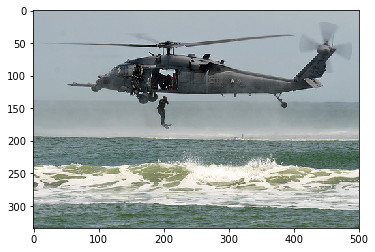

'man jump from helicopter into lake'

In [272]:
img = mpimg.imread(photo)
plt.imshow(img)
plt.show()
generate_caption(photo,model,vgg_model)